In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

7640


In [2]:
import cv2
from tqdm import tqdm

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 282


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

# Part 2: watershed

In [14]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        continue
        
    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_0.npy already exists, skip
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_001.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.048s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.147s.
- Finished illumination correction in 1.382s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_001.dax
-- 

-- corrected illumination for channel 750 in 4.191s.
-- corrected illumination for channel 488 in 4.314s.
-- corrected illumination for channel 405 in 4.292s.
- Finished illumination correction in 12.894s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.08 -35.75 -10.6 ] in 0.626s.
-- drift 1: [ 2.000e-02 -3.576e+01 -1.085e+01] in 0.577s.
-- drift 2: [ 1.000e-02 -3.567e+01 -1.074e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.03666667 -35.72666667 -10.73      ] for channel: 750
-- finish warpping channel 750 in 16.421s.
-- finish warpping in 16.421s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_4.npy
- run watershed in 94.070s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segme

- Loaded images for channels:['488'] in 0.978s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.187s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_008.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.761s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.242s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -3.336e+01 -2.029e+01] in 0.613s.
-- drift 1: [  0.   -33.16 -20.36] in 0.615s.
-- drift 2: [-2.000e-02 -3.322e+01 -2.015e+01] in 0.634s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -3.32466667e+01 -2.02666667e+01] for channel: 750
-- finish warpping channel 750 in 16.472s.
-- finish warpping in 16.472s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_11.npy
- run watershed in 100.775s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_11.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_012.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_012.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-

- Loaded images for channels:['488'] in 1.003s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.100s.
- Finished illumination correction in 1.154s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_015.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.643s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.286s.
-- corrected illuminat

-- drift 0: [-2.000e-02 -3.268e+01 -1.760e+01] in 0.549s.
-- drift 1: [ -0.04 -32.75 -17.34] in 0.591s.
-- drift 2: [-1.000e-02 -3.256e+01 -1.779e+01] in 0.522s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.33333333e-02 -3.26633333e+01 -1.75766667e+01] for channel: 750
-- finish warpping channel 750 in 16.284s.
-- finish warpping in 16.284s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_18.npy
- run watershed in 92.226s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_18.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_019.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_019.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-h

- Loaded images for channels:['488'] in 1.067s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.083s.
- Finished illumination correction in 1.146s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_022.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.412s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.157s.
-- corrected illuminat

-- drift 0: [ -0.04 -32.68 -10.27] in 0.626s.
-- drift 1: [ -0.04 -32.37 -10.08] in 0.625s.
-- drift 2: [ -0.08 -32.22 -10.55] in 0.632s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.05333333 -32.42333333 -10.3       ] for channel: 750
-- finish warpping channel 750 in 16.581s.
-- finish warpping in 16.581s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_25.npy
- run watershed in 98.640s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_25.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_026.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_026.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_0

-- corrected illumination for channel 488 in 1.131s.
- Finished illumination correction in 1.240s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_029.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.713s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.251s.
-- corrected illumination for channel 488 in 4.537s.
-- corrected illumination for channel 405 in 4.474s.
- Finished illumination correction in 13.452s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-3.33333333e-03 -3.19733333e+01 -1.70300000e+01] for channel: 750
-- finish warpping channel 750 in 16.428s.
-- finish warpping in 16.444s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_32.npy
- run watershed in 87.744s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_32.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_033.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_033.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_033.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.102s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 3.268s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.255s.
-- corrected illumination for channel 488 in 4.267s.
-- corrected illumination for channel 405 in 4.302s.
- Finished illumination correction in 13.013s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.05 -30.9  -17.68] in 0.595s.
-- drift 1: [  0.05 -30.7  -17.66] in 0.549s.
-- drift 2: [ 2.000e-02 -3.066e+01 -1.771e+01] in 0.534s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04       

- run watershed in 93.595s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_39.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_040.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_040.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_040.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.089s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.169s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M1

- Loaded images for channels:['750', '488', '405'] in 3.048s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.414s.
-- corrected illumination for channel 488 in 4.537s.
-- corrected illumination for channel 405 in 4.608s.
- Finished illumination correction in 13.789s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.118e+01 -1.449e+01] in 0.605s.
-- drift 1: [ 2.000e-02 -3.090e+01 -1.464e+01] in 0.619s.
-- drift 2: [  0.   -30.88 -14.3 ] in 0.611s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 87.383s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_46.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_047.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_047.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_047.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.076s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.083s.
- Finished illumination correction in 1.208s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M1

-- corrected illumination for channel 750 in 4.223s.
-- corrected illumination for channel 488 in 4.266s.
-- corrected illumination for channel 405 in 4.441s.
- Finished illumination correction in 13.053s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -30.27 -18.06] in 0.554s.
-- drift 1: [  0.   -29.98 -17.74] in 0.551s.
-- drift 2: [-2.000e-02 -3.018e+01 -1.781e+01] in 0.559s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-6.66666667e-03 -3.01433333e+01 -1.78700000e+01] for channel: 750
-- finish warpping channel 750 in 16.390s.
-- finish warpping in 16.390s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_50.npy
- run watershed in 82.142s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segment

- Loaded images for channels:['488'] in 0.940s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.098s.
- Finished illumination correction in 1.136s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_054.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.682s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.472s.
-- corrected illuminat

-- drift 0: [ 2.000e-02 -2.980e+01 -1.365e+01] in 0.549s.
-- drift 1: [  0.03 -29.8  -13.82] in 0.565s.
-- drift 2: [-1.000e-02 -2.977e+01 -1.349e+01] in 0.580s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -2.97900000e+01 -1.36533333e+01] for channel: 750
-- finish warpping channel 750 in 16.973s.
-- finish warpping in 16.973s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_57.npy
- run watershed in 76.145s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_57.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_058.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_058.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-h

-- corrected illumination for channel 488 in 1.142s.
- Finished illumination correction in 1.189s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_061.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.655s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.409s.
-- corrected illumination for channel 488 in 4.288s.
-- corrected illumination for channel 405 in 4.266s.
- Finished illumination correction in 13.072s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ 3.33333333e-02 -3.43700000e+01 -1.82200000e+01] for channel: 750
-- finish warpping channel 750 in 16.412s.
-- finish warpping in 16.412s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_64.npy
- run watershed in 98.958s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_64.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_065.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_065.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_065.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.020s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.695s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.207s.
-- corrected illumination for channel 488 in 4.216s.
-- corrected illumination for channel 405 in 4.520s.
- Finished illumination correction in 13.052s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 3.000e-02 -3.085e+01 -1.525e+01] in 0.595s.
-- drift 1: [ 1.000e-02 -3.144e+01 -1.518e+01] in 0.620s.
-- drift 2: [  0.   -30.99 -15.93] in 0.583s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 92.450s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_71.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_072.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_072.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_072.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.101s.
- Finished illumination correction in 1.194s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M1

- Loaded images for channels:['750', '488', '405'] in 2.989s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.201s.
-- corrected illumination for channel 488 in 4.170s.
-- corrected illumination for channel 405 in 4.176s.
- Finished illumination correction in 12.678s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.143e+01 -7.600e+00] in 0.561s.
-- drift 1: [  0.05 -30.9   -7.17] in 0.630s.
-- drift 2: [ 2.000e-02 -3.173e+01 -6.970e+00] in 0.608s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 84.175s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_78.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_079.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_079.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_079.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.073s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.145s.
- Finished illumination correction in 1.308s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M1

-- corrected illumination for channel 750 in 4.202s.
-- corrected illumination for channel 488 in 4.320s.
-- corrected illumination for channel 405 in 4.366s.
- Finished illumination correction in 13.060s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.08 -30.46 -17.46] in 0.621s.
-- drift 1: [ -0.04 -30.43 -17.6 ] in 0.570s.
-- drift 2: [ -0.05 -30.   -17.56] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.05666667 -30.29666667 -17.54      ] for channel: 750
-- finish warpping channel 750 in 16.368s.
-- finish warpping in 16.368s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_82.npy
- run watershed in 92.821s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_82.npy
re

- Loaded images for channels:['488'] in 1.111s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.177s.
- Finished illumination correction in 1.184s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_086.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.133s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.786s.
-- corrected illuminat

-- drift 0: [  0.08 -31.02 -10.65] in 0.557s.
-- drift 1: [  0.12 -30.87 -10.76] in 0.620s.
-- drift 2: [  0.07 -30.73 -10.67] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.09       -30.87333333 -10.69333333] for channel: 750
-- finish warpping channel 750 in 16.311s.
-- finish warpping in 16.311s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_89.npy
- run watershed in 84.343s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_89.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_090.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_090.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_0

-- corrected illumination for channel 488 in 1.148s.
- Finished illumination correction in 1.247s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_093.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.166s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.451s.
-- corrected illumination for channel 488 in 4.254s.
-- corrected illumination for channel 405 in 4.265s.
- Finished illumination correction in 13.126s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ 1.66666667e-02 -3.04733333e+01 -1.81900000e+01] for channel: 750
-- finish warpping channel 750 in 16.601s.
-- finish warpping in 16.601s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_96.npy
- run watershed in 89.949s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_96.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_097.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_097.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_097.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.058s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.794s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.470s.
-- corrected illumination for channel 488 in 4.396s.
-- corrected illumination for channel 405 in 4.425s.
- Finished illumination correction in 13.434s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.13 -30.21 -15.26] in 0.547s.
-- drift 1: [  0.04 -30.21 -15.57] in 0.642s.
-- drift 2: [ 2.000e-02 -3.120e+01 -1.543e+01] in 0.581s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.06333333 

- run watershed in 95.998s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_103.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_104.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_104.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_104.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.002s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction in 1.221s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

- Loaded images for channels:['750', '488', '405'] in 2.887s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.508s.
-- corrected illumination for channel 488 in 4.274s.
-- corrected illumination for channel 405 in 4.273s.
- Finished illumination correction in 13.212s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -2.316e+01 -9.470e+00] in 0.578s.
-- drift 1: [ 1.000e-02 -2.353e+01 -9.700e+00] in 0.582s.
-- drift 2: [ 2.000e-02 -2.292e+01 -9.660e+00] in 0.571s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

- run watershed in 93.092s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_110.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_111.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_111.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_111.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.087s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.081s.
- Finished illumination correction in 1.143s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

-- corrected illumination for channel 750 in 4.340s.
-- corrected illumination for channel 488 in 4.479s.
-- corrected illumination for channel 405 in 4.267s.
- Finished illumination correction in 13.117s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.06 -30.45 -14.86] in 0.587s.
-- drift 1: [  0.07 -29.29 -14.93] in 0.562s.
-- drift 2: [  0.03 -29.8  -14.88] in 0.624s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.05333333 -29.84666667 -14.89      ] for channel: 750
-- finish warpping channel 750 in 16.305s.
-- finish warpping in 16.305s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_114.npy
- run watershed in 88.129s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_114.npy


- Loaded images for channels:['488'] in 1.098s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.083s.
- Finished illumination correction in 1.176s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_118.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.253s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.276s.
-- corrected illuminat

-- drift 0: [  0.04 -30.53 -12.83] in 0.564s.
-- drift 1: [  0.08 -30.83 -13.36] in 0.566s.
-- drift 2: [  0.05 -29.98 -12.75] in 0.549s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.05666667 -30.44666667 -12.98      ] for channel: 750
-- finish warpping channel 750 in 16.462s.
-- finish warpping in 16.462s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_121.npy
- run watershed in 84.302s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_121.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_122.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_122.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.144s.
- Finished illumination correction in 1.206s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_125.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.900s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.200s.
-- corrected illumination for channel 488 in 4.250s.
-- corrected illumination for channel 405 in 4.205s.
- Finished illumination correction in 12.819s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-6.66666667e-03 -2.99300000e+01 -1.20266667e+01] for channel: 750
-- finish warpping channel 750 in 16.464s.
-- finish warpping in 16.464s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_128.npy
- run watershed in 89.367s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_128.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_129.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_129.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_129.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 2.076s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

- Loaded images for channels:['750', '488', '405'] in 3.171s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.190s.
-- corrected illumination for channel 488 in 4.225s.
-- corrected illumination for channel 405 in 4.282s.
- Finished illumination correction in 12.853s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.00e-02 -2.93e+01 -3.04e+01] in 0.628s.
-- drift 1: [ 1.000e-02 -2.922e+01 -2.984e+01] in 0.534s.
-- drift 2: [ 1.000e-02 -2.964e+01 -3.059e+01] in 0.565s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with

- run watershed in 79.323s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_135.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_136.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_136.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_136.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.174s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.162s.
- Finished illumination correction in 1.224s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

-- corrected illumination for channel 750 in 4.639s.
-- corrected illumination for channel 488 in 4.674s.
-- corrected illumination for channel 405 in 4.609s.
- Finished illumination correction in 13.938s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -29.27 -17.57] in 0.550s.
-- drift 1: [ -0.03 -29.13 -17.45] in 0.596s.
-- drift 2: [ -0.05 -29.66 -17.57] in 0.591s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03666667 -29.35333333 -17.53      ] for channel: 750
-- finish warpping channel 750 in 16.302s.
-- finish warpping in 16.302s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_139.npy
- run watershed in 80.249s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_139.npy


- Loaded images for channels:['488'] in 1.017s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.082s.
- Finished illumination correction in 1.241s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_143.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.854s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.256s.
-- corrected illuminat

-- drift 0: [ -0.11 -29.77 -26.18] in 0.569s.
-- drift 1: [ -0.03 -29.28 -25.74] in 0.566s.
-- drift 2: [ -0.15 -30.27 -25.19] in 0.566s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.09666667 -29.77333333 -25.70333333] for channel: 750
-- finish warpping channel 750 in 16.351s.
-- finish warpping in 16.352s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_146.npy
- run watershed in 76.288s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_146.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_147.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_147.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.142s.
- Finished illumination correction in 1.220s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_150.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.817s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.249s.
-- corrected illumination for channel 488 in 4.306s.
-- corrected illumination for channel 405 in 4.438s.
- Finished illumination correction in 13.156s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ -0.03666667 -28.92333333 -18.3       ] for channel: 750
-- finish warpping channel 750 in 16.357s.
-- finish warpping in 16.357s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_153.npy
- run watershed in 81.423s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_153.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_154.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_154.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_154.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.100s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.946s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.552s.
-- corrected illumination for channel 488 in 4.643s.
-- corrected illumination for channel 405 in 4.488s.
- Finished illumination correction in 13.716s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -2.880e+01 -1.153e+01] in 0.562s.
-- drift 1: [ 2.000e-02 -2.884e+01 -1.129e+01] in 0.596s.
-- drift 2: [  0.04 -28.51 -11.44] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 89.406s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_160.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_161.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_161.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_161.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.075s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.075s.
- Finished illumination correction in 1.200s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

- Loaded images for channels:['750', '488', '405'] in 3.029s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.239s.
-- corrected illumination for channel 488 in 4.290s.
-- corrected illumination for channel 405 in 4.691s.
- Finished illumination correction in 13.376s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-2.000e-02 -2.913e+01 -4.640e+00] in 0.547s.
-- drift 1: [ 1.000e-02 -2.871e+01 -4.270e+00] in 0.592s.
-- drift 2: [  0.   -28.31  -4.53] in 0.569s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-

- run watershed in 81.615s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_167.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_168.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_168.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_168.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.114s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.219s.
- Finished illumination correction in 1.219s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

-- corrected illumination for channel 750 in 4.256s.
-- corrected illumination for channel 488 in 4.315s.
-- corrected illumination for channel 405 in 4.472s.
- Finished illumination correction in 13.242s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.04 -29.64 -11.89] in 0.562s.
-- drift 1: [ -0.03 -29.25 -11.58] in 0.625s.
-- drift 2: [ -0.09 -29.9  -11.69] in 0.614s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.05333333 -29.59666667 -11.72      ] for channel: 750
-- finish warpping channel 750 in 16.865s.
-- finish warpping in 16.865s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_171.npy
- run watershed in 71.618s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_171.npy


- Loaded images for channels:['488'] in 0.987s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.077s.
- Finished illumination correction in 1.157s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_175.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.885s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.167s.
-- corrected illuminat

-- drift 0: [  0.03 -28.53  -6.21] in 0.517s.
-- drift 1: [  0.04 -28.27  -6.21] in 0.532s.
-- drift 2: [  0.07 -29.01  -6.73] in 0.581s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04666667 -28.60333333  -6.38333333] for channel: 750
-- finish warpping channel 750 in 16.255s.
-- finish warpping in 16.255s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_178.npy
- run watershed in 85.787s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_178.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_179.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_179.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.061s.
- Finished illumination correction in 1.188s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_182.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.288s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.182s.
-- corrected illumination for channel 488 in 4.173s.
-- corrected illumination for channel 405 in 4.197s.
- Finished illumination correction in 12.739s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ -0.05       -29.95666667 -12.78333333] for channel: 750
-- finish warpping channel 750 in 16.302s.
-- finish warpping in 16.302s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_185.npy
- run watershed in 81.645s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_185.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_186.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_186.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_186.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.063s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 3.083s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.204s.
-- corrected illumination for channel 488 in 4.228s.
-- corrected illumination for channel 405 in 4.206s.
- Finished illumination correction in 12.764s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.12 -28.11   0.  ] in 0.582s.
-- drift 1: [ -0.07 -29.37 -10.44] in 0.549s.
-- drift 2: [ -0.07 -28.68 -10.33] in 0.595s.
-- drift 3: [ -0.04 -29.76 -10.53] in 0.533s.
-- drift 4: [ -0.13 -28.93 -10.91] in 0.534s.
-- drift 5: [-2.000e-02 -2.870e+01 -1.065e+01] in 0.564s.
-- drift 6: [-2.000

-- warp image with drift:[ -0.10333333 -27.25       -17.76      ] for channel: 750
-- finish warpping channel 750 in 16.249s.
-- finish warpping in 16.249s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_192.npy
- run watershed in 79.668s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_192.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_193.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_193.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_193.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.045s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.831s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.142s.
-- corrected illumination for channel 488 in 4.222s.
-- corrected illumination for channel 405 in 4.180s.
- Finished illumination correction in 12.670s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -29.29 -15.89] in 0.551s.
-- drift 1: [  0.   -29.2  -16.02] in 0.555s.
-- drift 2: [ -0.07 -29.73 -15.9 ] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03333333 -29.40666667

- run watershed in 90.108s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_199.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_200.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_200.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_200.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.083s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.067s.
- Finished illumination correction in 1.132s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

- Loaded images for channels:['750', '488', '405'] in 2.671s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.178s.
-- corrected illumination for channel 488 in 4.227s.
-- corrected illumination for channel 405 in 4.216s.
- Finished illumination correction in 12.730s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.03 -28.93  -3.78] in 0.550s.
-- drift 1: [  0.06 -28.47  -3.92] in 0.565s.
-- drift 2: [  0.03 -28.72  -3.7 ] in 0.550s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04       -28.70666667

- run watershed in 84.078s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_206.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_207.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_207.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_207.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.999s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.082s.
- Finished illumination correction in 1.124s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

-- corrected illumination for channel 750 in 4.205s.
-- corrected illumination for channel 488 in 4.225s.
-- corrected illumination for channel 405 in 4.288s.
- Finished illumination correction in 12.827s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -28.45 -13.42] in 0.646s.
-- drift 1: [-2.000e-02 -2.868e+01 -1.333e+01] in 0.550s.
-- drift 2: [-1.000e-02 -2.863e+01 -1.349e+01] in 0.595s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -2.85866667e+01 -1.34133333e+01] for channel: 750
-- finish warpping channel 750 in 16.340s.
-- finish warpping in 16.340s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_210.npy
- run watershed in 83.427s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\wate

- Loaded images for channels:['488'] in 0.974s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.092s.
- Finished illumination correction in 1.226s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_214.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.652s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.190s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -2.722e+01 -1.599e+01] in 0.592s.
-- drift 1: [  0.08 -27.06 -16.26] in 0.559s.
-- drift 2: [  0.05 -27.41 -15.97] in 0.580s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04666667 -27.23       -16.07333333] for channel: 750
-- finish warpping channel 750 in 16.457s.
-- finish warpping in 16.457s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_217.npy
- run watershed in 85.199s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_217.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_218.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_218.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M

-- corrected illumination for channel 488 in 1.060s.
- Finished illumination correction in 1.219s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_221.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.643s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.218s.
-- corrected illumination for channel 488 in 4.292s.
-- corrected illumination for channel 405 in 4.344s.
- Finished illumination correction in 13.018s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.13333333 -28.11666667  -2.03666667] for channel: 750
-- finish warpping channel 750 in 16.657s.
-- finish warpping in 16.657s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_224.npy
- run watershed in 83.556s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_224.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_225.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_225.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_225.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.052s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.715s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.221s.
-- corrected illumination for channel 488 in 4.362s.
-- corrected illumination for channel 405 in 4.275s.
- Finished illumination correction in 12.968s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -27.48 -17.37] in 0.594s.
-- drift 1: [  0.   -27.04 -17.39] in 0.580s.
-- drift 2: [-2.000e-02 -2.709e+01 -1.767e+01] in 0.563s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-

- run watershed in 91.150s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_231.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_232.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_232.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_232.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.003s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.162s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M

-- corrected illumination for channel 750 in 4.162s.
-- corrected illumination for channel 488 in 4.181s.
-- corrected illumination for channel 405 in 4.197s.
- Finished illumination correction in 12.696s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -27.74 -21.17] in 0.518s.
-- drift 1: [  0.04 -27.21 -21.18] in 0.596s.
-- drift 2: [  0.08 -27.15 -21.23] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04       -27.36666667 -21.19333333] for channel: 750
-- finish warpping channel 750 in 16.256s.
-- finish warpping in 16.256s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_235.npy
- run watershed in 72.900s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_235.npy


- Loaded images for channels:['488'] in 1.040s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.080s.
- Finished illumination correction in 1.224s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_239.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.679s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.167s.
-- corrected illuminat

-- drift 0: [ -0.06 -28.41  -8.44] in 0.533s.
-- drift 1: [ -0.03 -28.26  -8.95] in 0.548s.
-- drift 2: [ -0.03 -28.58  -8.82] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.04       -28.41666667  -8.73666667] for channel: 750
-- finish warpping channel 750 in 16.250s.
-- finish warpping in 16.250s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_242.npy
- run watershed in 75.304s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_242.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_243.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_243.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan

<IPython.core.display.Javascript object>


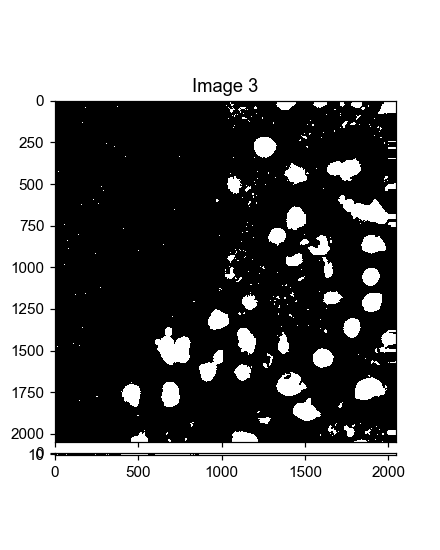

In [11]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


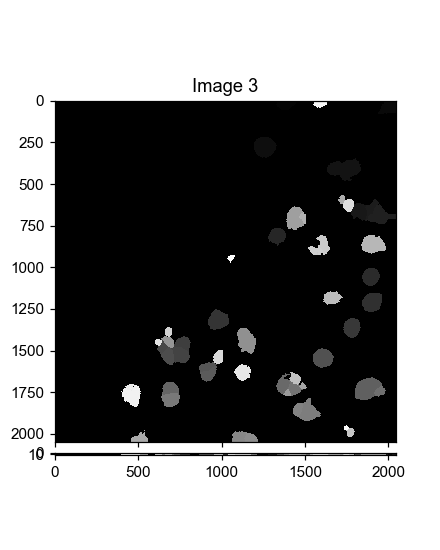

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels])

In [ ]:
wate